# Validation Set 1.2: diffuPy + PathMe  

In [1]:
import os
import itertools

import time

dir_path = os.path.dirname(os.path.realpath('__file__'))

In [2]:
from openpyxl import load_workbook
from collections import defaultdict
import networkx as nx

In [3]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

In [4]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

In [5]:
import diffupy

In [6]:
from diffupy.diffuse import diffuse
from diffupy.kernels import regularised_laplacian_kernel
from diffupy.matrix import Matrix, LaplacianMatrix
from diffupy.input_mapping import generate_categoric_input_from_labels, get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupy.validation_datasets_parsers import parse_set2
from diffupy.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_label_list_graph
from diffupy.views import show_heatmap


In [7]:
# TODO
import nbimporter
from global_database_comparison import get_set_database, calculate_database_sets_as_dict

Importing Jupyter notebook from global_database_comparison.ipynb


## 1. Load Data Set 2: Input Scores

In [8]:
dataset2_labels_by_omics = parse_set2(os.path.join(dir_path, 'validation', 'set2.xlsx'))

In [9]:
dataset2_labels_by_omics

defaultdict(<function diffupy.validation_datasets_parsers.parse_set2.<locals>.<lambda>()>,
            {'metabolite': {('nεtrimethyllysine', 'nε'),
              '2aminoadipicacid',
              '5methylthioadenosine',
              'adenosine',
              'alanylglycine',
              'alanylleucine',
              'bilirubin',
              'biliverdine',
              'carnitine',
              'carnitinec10:0',
              'carnitinec14:1',
              'carnitinec14:2',
              'carnitinec16:1',
              'carnitinec16:2',
              'carnitinec18:0',
              'carnitinec4:0oh',
              'carnitinec5:0oh',
              'carnitinec6:0',
              'carnitinec6:0oh',
              'carnitinec8:0',
              'carnitinec8:1',
              'cdca',
              'cdpcholine',
              'choline',
              'cholineglycerophosphate',
              'dheasulfate',
              'dpantothenicacid',
              'etiocholanolonesulfate',
     

In [10]:
print_dict_dimensions(dataset2_labels_by_omics, 'Dataset1 imported labels:')

Dataset1 imported labels:
Total number of metabolite: 60  
Total number of genes: 31  
Total number of micrornas: 16  
Total: 107 


In [11]:
dataset2_all_labels = get_labels_set_from_dict(dataset2_labels_by_omics)

## 2. Load Backrgound Graph Universe

### 2.1. PathMeUniverse import

In [12]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(PATHME_DIR, 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))



In [13]:
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

##### Get KEGG subgraph

In [14]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

##### Check isolates / Unconnected nodes

In [15]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [16]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

In [17]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

0

### 2.2. Get labels subsets by entity type (omic) and database

##### PathMe package subsets

In [18]:
def get_labels_by_db_and_omic_from_pathme(databases):
    db_entites = defaultdict(dict)
    entites_db = defaultdict(lambda: defaultdict(set))
    
    for db in databases:
        genes, mirna, metabolites, bps = get_set_database(db)
        db_entites[db] = {'genes': genes, 'mirna': mirna, 'metabolites': metabolites, 'bps': bps}
        
        for entity_type, entities in db_entites[db].items():
            entites_db[entity_type][db] = entities
            
    return db_entites, entites_db

In [19]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimensions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')



Entities in PathMe package :
Total number of reactome: genes(8653), mirna(13), metabolites(2712), bps(2219),  
Total number of kegg: genes(7656), mirna(149), metabolites(4421), bps(418),  
Total number of wikipathways: genes(3361), mirna(91), metabolites(657), bps(135),  
Total: 30485 


In [20]:
bg_labels_from_pathme_by_omic = reduce_dict_dimension(bg_labels_from_pathme_by_omic_and_db)
mirnas = bg_labels_from_pathme_by_omic['mirna']

#####  PathMeUniverse Graph Subsets

In [21]:
def get_labels_by_db_and_omic_from_graph(graph):
    
    db_subsets = defaultdict(set)
    db_entites = defaultdict(dict)
    entites_db = defaultdict(dict)

    #entity_type_map = {'Gene':'genes', 'mirna_nodes':'mirna', 'Abundance':'metabolites', 'BiologicalProcess':'bps'}

    for u, v, k in graph.edges(keys=True):
        if ANNOTATIONS not in graph[u][v][k]:
            continue
            
        if 'database' not in graph[u][v][k][ANNOTATIONS]:
            continue
            
        for database in graph[u][v][k][ANNOTATIONS]['database']:
            db_subsets[database].add(u)
            db_subsets[database].add(v)
        
    for database, nodes in db_subsets.items():
        db_entites[database] = calculate_database_sets_as_dict(nodes, database)
        
        database_sets = calculate_database_sets_as_dict(nodes, database)
        
        db_entites[database] = database_sets
    
        for entity_type, entities in database_sets.items():
            entites_db[entity_type][database] = entities
        
    return db_entites, entites_db

In [22]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total number of reactome: gene_nodes(8615), mirna_nodes(13), metabolite_nodes(2684), bp_nodes(5),  
Total number of wikipathways: gene_nodes(2549), mirna_nodes(91), metabolite_nodes(618), bp_nodes(152),  
Total: 22750 


### Background  Matrix Kernels

In [23]:
then = time.time()

In [24]:
#background_mat = regularised_laplacian_kernel(pathme_universe_graph_no_flatten)

In [25]:
import pickle
input_path = os.path.join(PATHME_DIR, 'regularized_kernel_pathme_universe.pickle')

with open(input_path, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    background_mat = unpickler.load()

In [26]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  121.44590401649475  seconds


### Row labels

In [27]:
background_labels = background_mat.rows_labels

In [28]:
mirnas = dataset2_labels_by_omics['micrornas']

## 3. Dataset label mapping to PathMeEntities

### General mapping

In [29]:
all_labels_mapping = get_mapping(dataset2_all_labels, background_labels, title = 'Global mapping: ', mirnas=mirnas, print_percentage = True)


Global mapping:  (39) 36.79245283018868%


### Mapping by subsets

#### Mapping by entity type/omic

In [30]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset2_labels_by_omics, background_labels, 'entity type/omic', mirnas=mirnas)


Mapping by entity type/omic:
metabolite (11) 18.333333333333332%
genes (28) 90.32258064516128%
micrornas (1) 6.25%
Total (40) 37.735849056603776% 



In [31]:
micrornas_mapping = mapping_by_entity['micrornas'][0]
micrornas_mapping

{'mir106b'}

#### Mapping by database

In [32]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset2_all_labels, 'database', mirnas=mirnas, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (32) 30.18867924528302%
reactome (15) 14.150943396226415%
wikipathways (22) 20.754716981132077%
Total (40) 37.735849056603776% 



#### Mapping by entity type and database

In [33]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset2_all_labels, relative_statistics = dataset2_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (26) 83.87096774193549%
mirna_nodes (1) 6.25%
metabolite_nodes (5) 8.333333333333332%
bp_nodes (0) 0%
Total (32) 0.39885329677178116% 

Mapping by Reactome:
gene_nodes (9) 29.03225806451613%
mirna_nodes (0) 0.0%
metabolite_nodes (6) 10.0%
bp_nodes (0) 0%
Total (15) 0.13254396041353717% 

Mapping by Wikipathways:
gene_nodes (12) 38.70967741935484%
mirna_nodes (1) 6.25%
metabolite_nodes (9) 15.0%
bp_nodes (0) 0%
Total (22) 0.6451612903225806% 

Total (40) 37.735849056603776% 



### Mapping descriptive view

In [34]:
# TODO

all_count = []
all_percentage = []

entity_type_map = {'metabolite_nodes': 'metabolite', 'mirna_nodes': 'micrornas', 'gene_nodes': 'genes',
                    'bp_nodes': 'bps'}

for db_name, entities_by_type in mapping_by_database_and_entity.items():
    db_count = []
    db_percentage = []

    for entity_type, entities_tupple in entities_by_type[0].items():
        db_count.append(len(entities_tupple[0]))
        db_percentage.append(entities_tupple[1])
        
        
    all_count.append(db_count)
    all_percentage.append(db_percentage)

db_count = []
db_percentage = []
for entity, entities_tupple in mapping_by_entity.items():
    db_count.append(len(entities_tupple[0]))
    db_percentage.append(entities_tupple[1])
    


In [35]:
import numpy as np

databases = list(mapping_by_database_and_entity.keys())
databases.append('arreu')


entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

In [36]:
databases = mapping_by_database_and_entity.keys()
entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

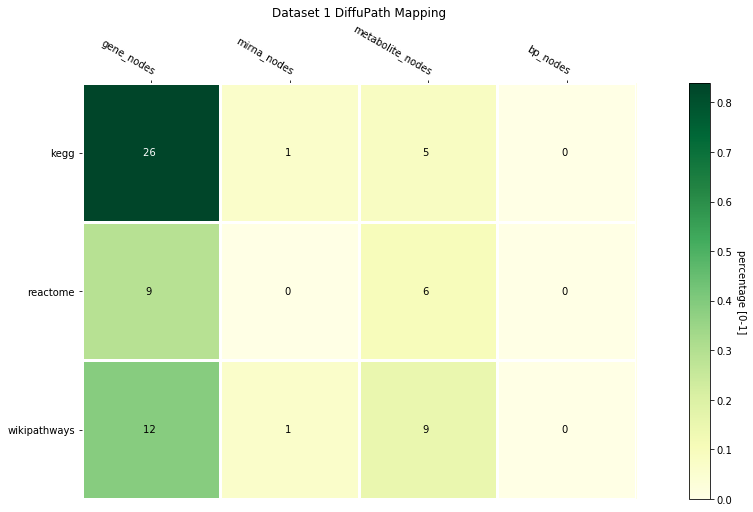

In [37]:
show_heatmap(entity_number, entity_count, databases, entity_types)

In [38]:
from diffupy.utils import get_three_venn_intersections
db_intersections = get_three_venn_intersections(mapping_by_db['kegg'][0], mapping_by_db['reactome'][0], mapping_by_db['wikipathways'][0])



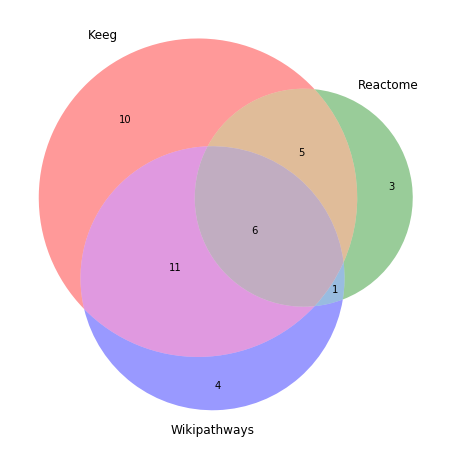

In [39]:
from diffupy.views import show_venn_diagram

show_venn_diagram(db_intersections)

In [40]:
from diffupy.utils import random_disjoint_intersection_three_subsets
disjoint_db_mapping = random_disjoint_intersection_three_subsets(mapping_by_db)


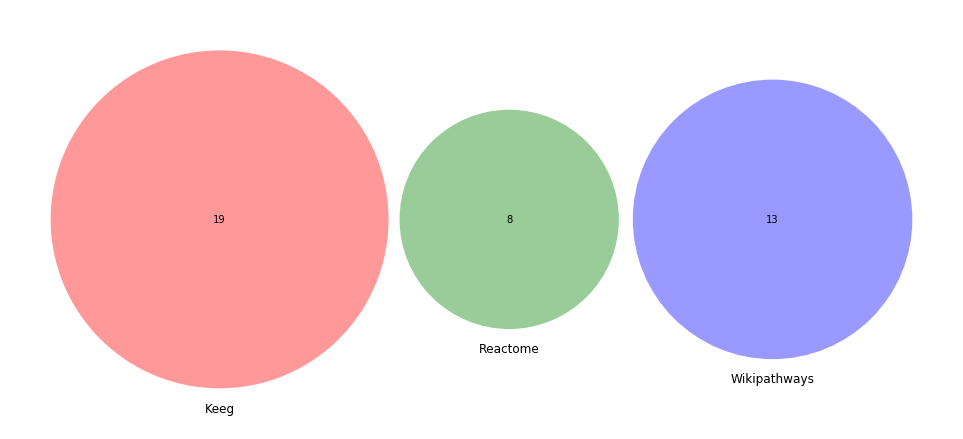

In [41]:
show_venn_diagram(get_three_venn_intersections(*list(disjoint_db_mapping.values())))


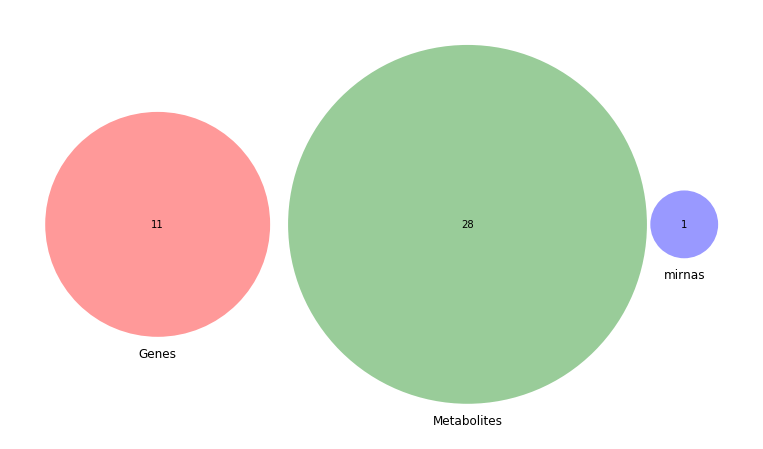

In [42]:
show_venn_diagram(get_three_venn_intersections(*(i[0] for i in mapping_by_entity.values())), 
                  set_labels = ('Genes', 'Metabolites', 'mirnas'))


## 5. Cross-validation

In [49]:
from diffupy.views import box_plot_from_dict
from diffupy.cross_validation import cross_validation_by_method, cross_validation_by_method, cross_validation_by_subset_same_diff_input, cross_validation_one_x_in



### 5.1. Random-validation Scheme

#### 5.1.1.  By method

In [44]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_by_method(all_labels_mapping, pathme_universe_graph_no_flatten, background_mat, k = 4)



100%|██████████| 4/4 [51:17<00:00, 774.21s/it]


In [46]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [47]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUPRC')

#### 5.1.2.  By entity

In [50]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 4)


100%|██████████| 4/4 [39:17<00:00, 594.89s/it]


In [48]:
import json

with open('metrics_set2_by_entity.txt', 'w') as outfile:  
    json.dump({'auroc_metrics_by_entity': auroc_metrics_by_method, 'auprc_metrics_by_entity': auprc_metrics_by_method}, outfile)

    

### 5.2. Leave Two DB Out (LTOO)

In [ ]:
mapping_by_db

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db,
                                                                              disjoint = True,
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Leave Two DB Out Validation', 'DB', 'AUROC')

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db, 
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

### 5.3. Leave Two DataBases Out (LTDBO)

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in(mapping_by_entity, background_mat, k = 1 )

In [ ]:
box_plot_from_dict(auroc_metrics_by_db, 'Leave Two Omics Out Validation', 'Entity type', 'AUPRC')